In [69]:


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *
from tqdm import tqdm
import pingouin as pg
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib

def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')
    
def plot_raw(data=None, y=None, x=None, isDay=None, ax=None, hzero=True):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,3))

    if x is None:
        x = data.index
    
    if hzero:
        ax.axhline(0,color='k',linestyle='--')
    
    ax.plot(x, data[y] )
    ax.set_ylim([data[y].min()*1.1, data[y].max()*1.1 ])
    ylims = ax.get_ylim()
    ax.fill_between(x, where=data['isDay']==0, 
                    y1=ylims[0], 
                    y2=ylims[1], 
                    color='gray', alpha=.2, edgecolor='None' )

    ax.set_xlim([x[0], x[-1]])
    return ax

def actogram(in_each_day, ax=None, baseline=True,linecolor='tab:blue',isDay=None):
    each_day = in_each_day.copy()

    each_day = each_day/each_day.abs().max().max()
    spacing = 1.5
    
    mot_day_tick = list()
    mot_day_tick_lbl = list()
    all_days = len(each_day.columns)
    for i,c in enumerate(each_day.columns):    
        each_day[c] = each_day[c] + spacing*(all_days-i)
        mot_day_tick.append(spacing*(all_days-i))
        mot_day_tick_lbl.append(i)
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(4,5))
        ax.set_ylabel('Day')
        ax.set_xlabel('Hour')
    if baseline:
        for b in mot_day_tick:
            ax.axhline(b,color='k',linestyle='--')
    ax.plot(each_day.index,each_day,linecolor)
    if isDay is not None:
        ylims = ax.get_ylim()
        ax.fill_between(isDay.index,y1=ylims[0],y2=ylims[1],where=isDay<1,color='gray',edgecolor='None',alpha=.4)
        
    ax.set_yticks(mot_day_tick)
    #ax.set_yticklabels(mot_day_tick_lbl)
    
    ax.set_xlim(each_day.index[0],each_day.index[-1])
    
    if isDay is None:
        ylims = ax.get_ylim()
    ax.set_ylim(ylims)
    


def swarmbox(data,x,y,ax=None,palette=None,order=None):
    PROPS = {'boxprops':{'facecolor':'none'}}
    sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
    sns.boxplot(data=data,x=x,y=y,palette=palette,ax=ax,order=order,width=0.3,fliersize=0, **PROPS)

    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    if len(box_patches) == 0:  
        box_patches = ax.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    if type(palette)==dict:
        palette=[i[1] for i in list(palette.items()) ]
    for i, patch in enumerate(box_patches):
        if i==0:
            col=palette[0]
        else:
            col=palette[1]
        patch.set_edgecolor(col)
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
    
%matplotlib notebook

In [2]:

pth = r'D:\thermography\cdkl5_thermal_behaviour_group1\unico'
#pth = None
sub = Subjects(pth)
print(sub)

Number of Subjects: 16

0 -> ID: KO_69 RECs: 3
1 -> ID: WT_71 RECs: 3
2 -> ID: KO_70 RECs: 3
3 -> ID: WT_74 RECs: 3
4 -> ID: WT_79 RECs: 3
5 -> ID: KO_72 RECs: 3
6 -> ID: WT_81 RECs: 3
7 -> ID: KO_75 RECs: 3
8 -> ID: KO_77 RECs: 3
9 -> ID: WT_83 RECs: 3
10 -> ID: KO_1021 RECs: 3
11 -> ID: WT_86 RECs: 3
12 -> ID: WT_91 RECs: 3
13 -> ID: KO_87 RECs: 3
14 -> ID: WT_97 RECs: 3
15 -> ID: KO_99 RECs: 3



In [3]:
data_min = sub.get_data(4)
data_min.head()

,minute,day,hour,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,distance,temp_rt_diff,temp_norm,RT_norm,temp_rt_corrected
0,600,1,10.0,22.767586,1.0,26.526408,26.526408,28.450860,84.345575,103.522996,0.025417,3.758822,-0.538646,-0.763585,0.224939
1,601,1,10.0,22.778073,1.0,26.572030,26.572030,28.575758,83.978223,103.364895,0.014407,3.793956,-0.493024,-0.753097,0.260074
2,602,1,10.0,22.782499,1.0,26.597252,26.597252,28.719703,83.834401,103.440393,0.013272,3.814753,-0.467802,-0.748672,0.280870
3,603,1,10.0,22.791886,1.0,26.625250,26.625250,28.878731,83.666816,103.526497,0.015060,3.833363,-0.439804,-0.739284,0.299481
4,604,1,10.0,22.801273,1.0,26.659680,26.659680,29.054798,83.511369,103.556523,0.010660,3.858407,-0.405373,-0.729897,0.324524


<IPython.core.display.Javascript object>


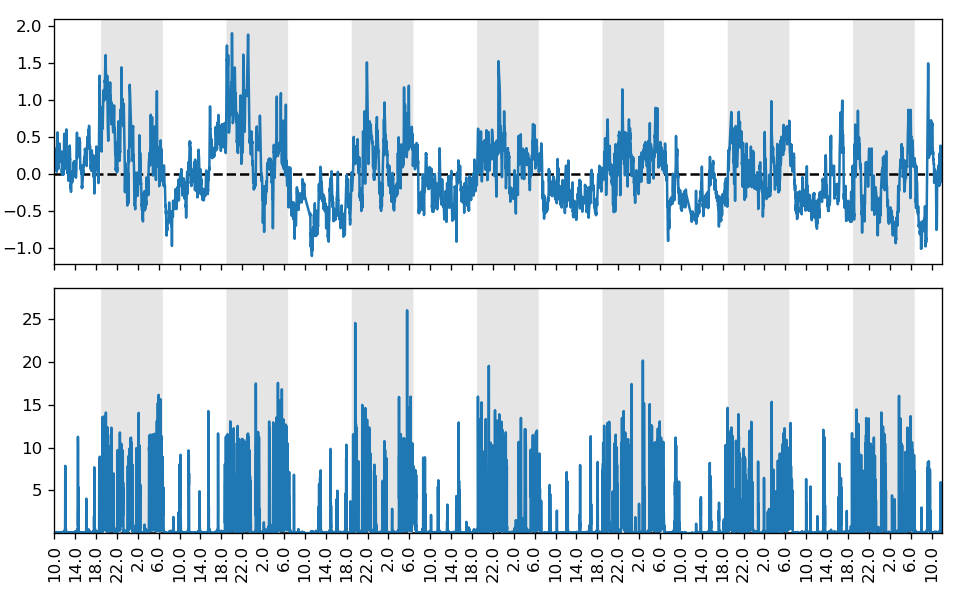

In [4]:


fig,ax = plt.subplots(2,1,figsize=(8,5),sharex=True )
plot_raw(data=data_min, y='temp_rt_corrected',ax=ax[0])
ax[0].grid(False)
ax[0].set_xticks(ticks=np.array(range(0,data_min.index[-1], 240)), labels=data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90 )
plot_raw(data=data_min, y='distance',ax=ax[1]) 
ax[1].set_xticks(np.array(range(0,data_min.index[-1], 240)), data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90  )
ax[1].grid(False)
plt.tight_layout()  





<IPython.core.display.Javascript object>


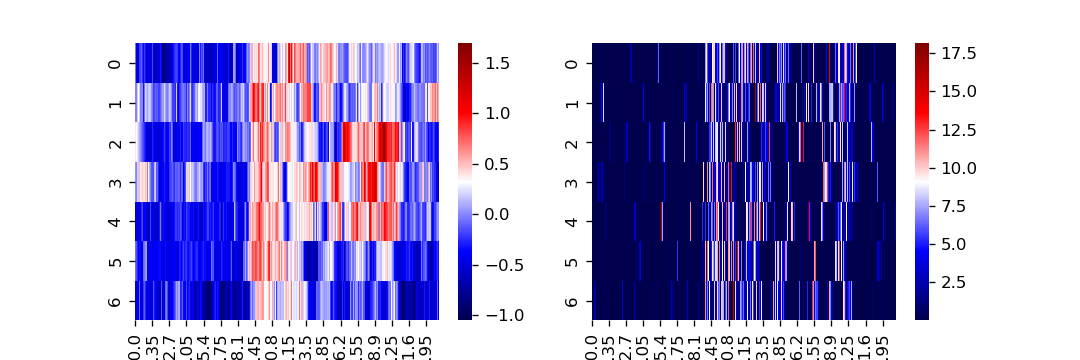

<Axes: >

In [34]:
import seaborn as sns

topo = 11
temperature_each_day = sub.get_days_df(topo,'temp_rt_corrected')
motion_each_day = sub.get_days_df(topo,'distance')
temperature_each_day.index = 10+(temperature_each_day.index/60)
motion_each_day.index = 10+(motion_each_day.index/60)
fig,ax = plt.subplots(1,2, figsize=(9,3))
#ax.axhline(0,color='k',linestyle='--')
sns.heatmap( temperature_each_day.T, cmap='seismic',ax=ax[0])
sns.heatmap( motion_each_day.T, cmap='seismic',ax=ax[1])#, vmin=-1.5, vmax=1.5) #, color='b', alpha=.2)
#ax.plot( temperature_each_day.mean(axis=1), color='b', alpha=1 )
#plt.show()


<IPython.core.display.Javascript object>


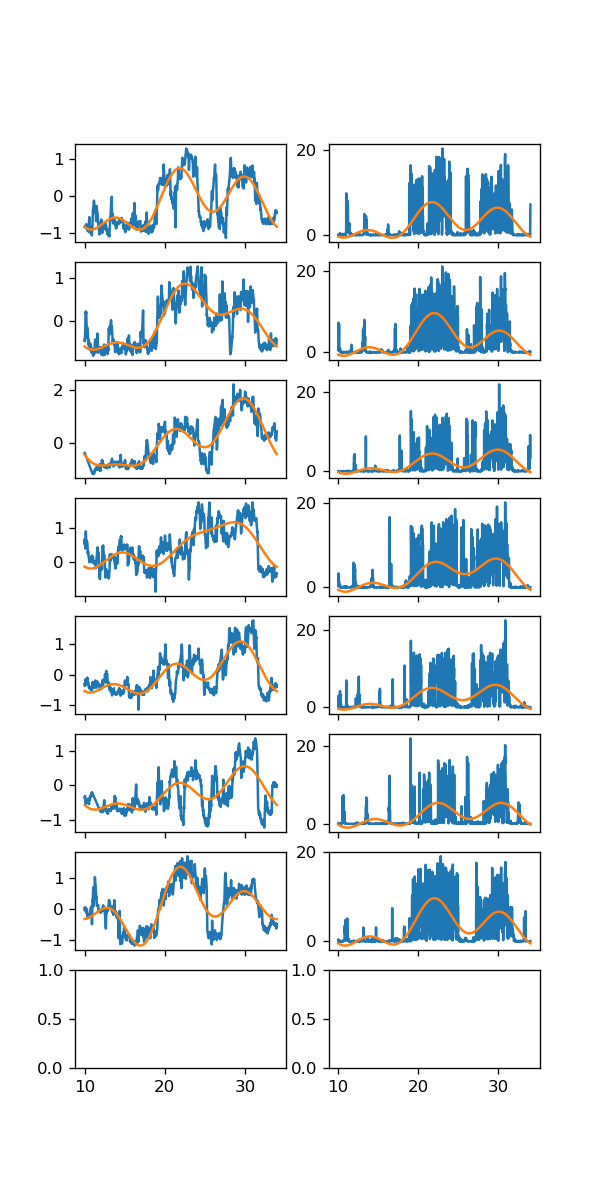

{'amplitude': [0.4523126316267736, 0.2925546434746585, 0.5375456242053623], 'period': [7.9900000000002, 11.990000000003098, 23.990000000000002], 'period_r': [8.0, 12.0, 24.0], 'acrophase': [5.889, 8.243, 1.347]}
{'amplitude': [2.375405070517331, 1.5863720009670588, 2.4298760359547438], 'period': [8.001905484284283, 11.990000000000002, 23.990000000000002], 'period_r': [8.0, 12.0, 24.0], 'acrophase': [5.76, 8.168, 1.094]}
{'amplitude': [0.25173677914107223, 0.16789519427341223, 0.6434174377474707], 'period': [7.990000000000033, 12.009999997818904, 23.990000000007015], 'period_r': [8.0, 12.0, 24.0], 'acrophase': [6.147, 9.731, 0.807]}
{'amplitude': [2.505246432768451, 1.8532446528033337, 3.019976643993852], 'period': [7.990000000000001, 11.990000000000924, 23.990000000000002], 'period_r': [8.0, 12.0, 24.0], 'acrophase': [6.01, 9.067, 23.974]}
{'amplitude': [0.39611337670606317, 0.5635884545334783, 0.8784822931148885], 'period': [7.990000000000001, 12.009999999999998, 24.009999999999998], 

In [6]:
fig,ax = plt.subplots(len(temperature_each_day.columns)+1,2,sharex=True,figsize=(5,10))

for i,d in enumerate(temperature_each_day.columns):
    cc_temp_day = Cosinor(temperature_each_day[d],temperature_each_day.index)
    temp_mesor, temp_component, temp_curve, temp_time = cc_temp_day.fitComponents([8,12,24],fixed=True)
    
    cc_mot_day = Cosinor(motion_each_day[d],temperature_each_day.index)
    temp_mesor, mot_component, mot_curve, mot_time = cc_mot_day.fitComponents([8,12,24],fixed=True)
    
    ax[i,0].plot(temp_time, temperature_each_day[d])
    ax[i,0].plot(temp_time,temp_curve)
    #ax[i,0].plot(temp_component['acrophase'],temp_component['mesor']+temp_component['amplitude'] ,'rs')
    
    ax[i,1].plot(mot_time, motion_each_day[d])
    ax[i,1].plot(mot_time,mot_curve)
    #ax[i,1].plot(mot_component['acrophase'],mot_component['mesor']+mot_component['amplitude'] ,'rs')
    

<IPython.core.display.Javascript object>


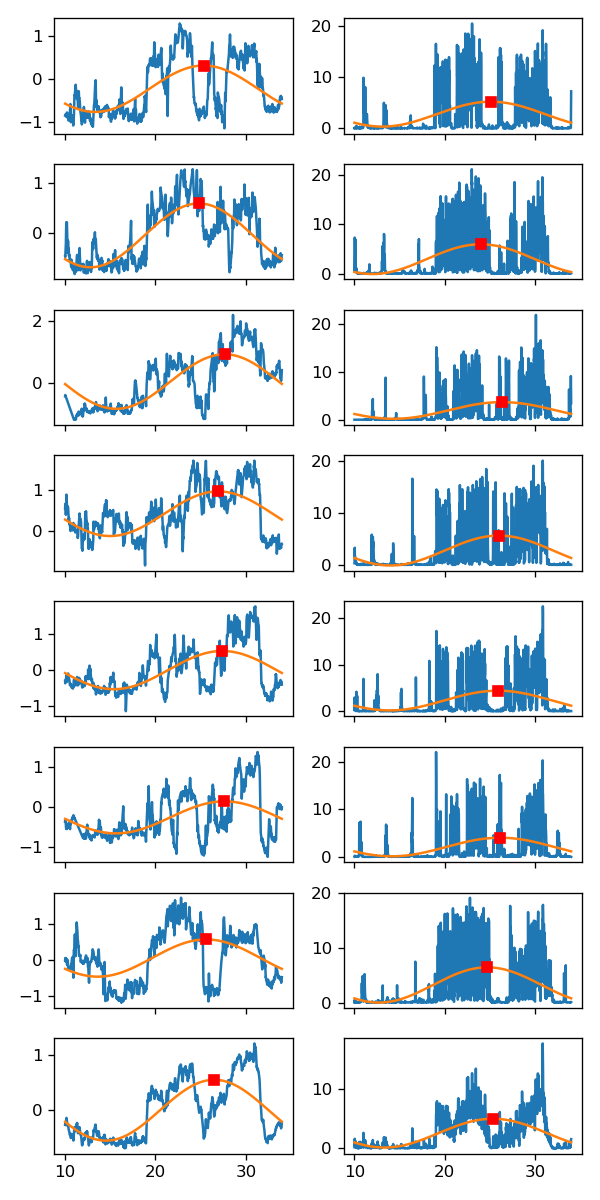

,mesor,amplitude,period,acrophase,r2
0,2.571519,2.422145,24.01,25.315,0.322112


In [7]:
fig,ax = plt.subplots(len(temperature_each_day.columns)+1,2,sharex=True,figsize=(5,10))

for i,d in enumerate(temperature_each_day.columns):
    cc_temp_day = Cosinor(temperature_each_day[d],temperature_each_day.index)
    cc_temp_day.fitComponent(24,fixed=True)
    
    cc_mot_day = Cosinor(motion_each_day[d],motion_each_day.index)
    cc_mot_day.fitComponent(24,fixed=True)
    
    ax[i,0].plot(cc_temp_day.time, temperature_each_day[d])
    ax[i,0].plot(cc_temp_day.time,cc_temp_day.curve)
    ax[i,0].plot(cc_temp_day.components['acrophase'],cc_temp_day.components['mesor']+cc_temp_day.components['amplitude'] ,'rs')
    
    ax[i,1].plot(cc_mot_day.time, motion_each_day[d])
    ax[i,1].plot(cc_mot_day.time,cc_mot_day.curve)
    ax[i,1].plot(cc_mot_day.components['acrophase'],cc_mot_day.components['mesor']+cc_mot_day.components['amplitude'] ,'rs')

cc_temp_day = Cosinor(temperature_each_day.mean(axis=1),temperature_each_day.index)
ax[i+1,0].plot(cc_temp_day.time, temperature_each_day.mean(axis=1))
ax[i+1,0].plot(cc_temp_day.time,cc_temp_day.curve)
ax[i+1,0].plot(cc_temp_day.components['acrophase'],cc_temp_day.components['mesor']+cc_temp_day.components['amplitude'] ,'rs')

cc_mot_day = Cosinor(motion_each_day.mean(axis=1),motion_each_day.index)
ax[i+1,1].plot(cc_mot_day.time, motion_each_day.mean(axis=1))
ax[i+1,1].plot(cc_mot_day.time,cc_mot_day.curve)
ax[i+1,1].plot(cc_mot_day.components['acrophase'],cc_mot_day.components['mesor']+cc_mot_day.components['amplitude'] ,'rs')

plt.tight_layout()
cc_mot_day.components

## Average 24h activity

In [8]:

# motion & temperature
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_day_avg() , total=len(sub) ):
    rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_corrected']
    isDay.append(rec['isDay'])
    
isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)
#time_range = pd.timedelta_range(start='0 days 10:00:00', end='1 days 09:59:00', freq='1min')





100%|██████████| 16/16 [00:00<00:00, 44.48it/s]


<IPython.core.display.Javascript object>


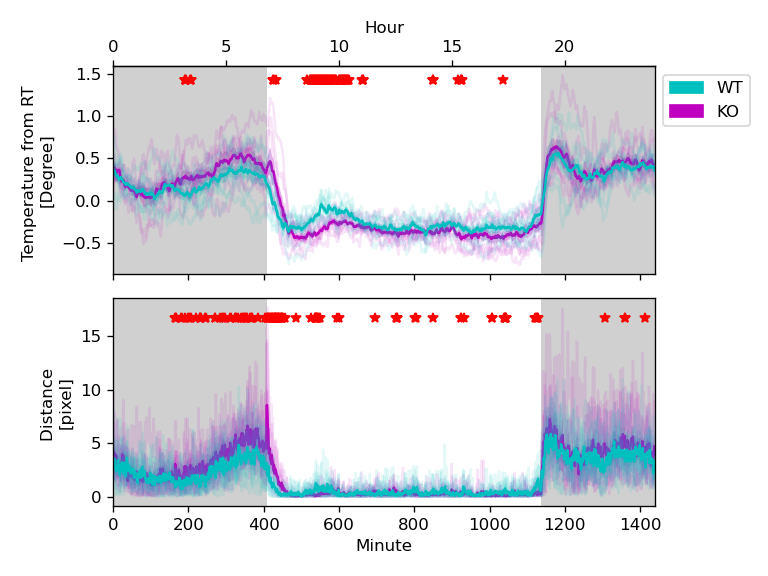

In [9]:
fig,ax = plt.subplots(2,1,sharex=True) 

wt_patch = mpatches.Patch(color='c', label='WT')
ko_patch = mpatches.Patch(color='m', label='KO')
ax[0].legend(handles=[wt_patch, ko_patch],bbox_to_anchor=(1, 1),)

plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

temperature_ttests = list()
for i,row in temperature.iterrows():
    temp = pg.ttest(row['WT'].values,row['KO'].values)
    temp['minute'] = i
    temperature_ttests.append( temp )
temperature_ttests = pd.concat(temperature_ttests).sort_values(by='p-val')    
reject, pvals_corr = pg.multicomp(temperature_ttests['p-val'], method='fdr_bh')
temperature_ttests['p-corr'] = pvals_corr

pval_signi = temperature_ttests[temperature_ttests['p-val']<0.05] #temperature_ttests[temperature_ttests['p-corr']<0.05]
signi_pos = np.max(ax[0].get_ylim())*.9
ax[0].plot( pval_signi.minute, np.repeat(signi_pos,len(pval_signi)),'*r' )

motion_ttests = list()
for i,row in motion.iterrows():
    temp = pg.ttest(row['WT'].values,row['KO'].values)
    temp['minute'] = i
    motion_ttests.append( temp )
motion_ttests = pd.concat(motion_ttests).sort_values(by='p-val')    
reject, pvals_corr = pg.multicomp(motion_ttests['p-val'], method='fdr_bh')
motion_ttests['p-corr'] = pvals_corr

pval_signi = motion_ttests[motion_ttests['p-val']<0.05] #motion_ttests[motion_ttests['p-corr']<0.05]
signi_pos = np.max(ax[1].get_ylim())*.9
ax[1].plot( pval_signi.minute, np.repeat(signi_pos,len(pval_signi)),'*r' )



plt.tight_layout()

## Average all track

In [10]:
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_data() , total=len(sub) ):
    #rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])

isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)

100%|██████████| 16/16 [00:01<00:00, 13.79it/s]


<IPython.core.display.Javascript object>


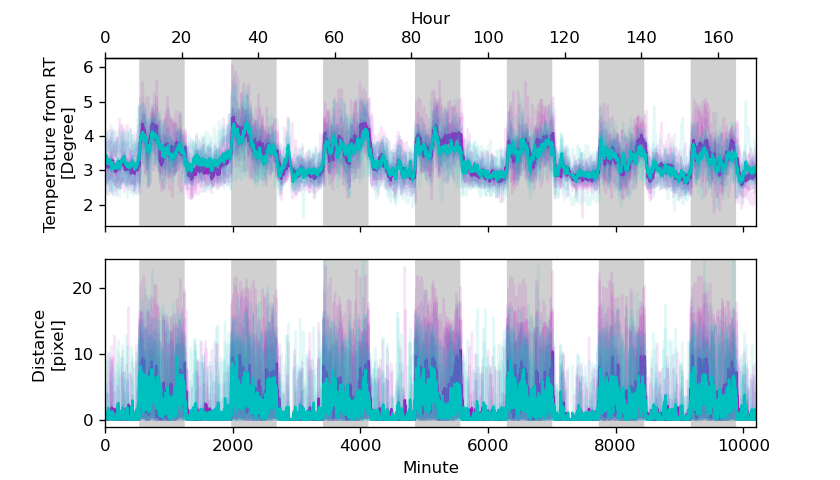

Text(0.5, 0, 'Minute')

In [11]:
fig,ax = plt.subplots(2,1,sharex=True, figsize=(7,4)) 
plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

## Cross Correlation

In [12]:
cc_data = list()
cross_corr_curves = list()
for i,(geno,chi) in enumerate(temperature.columns):
    cc = CrossCorrelation(temperature[geno][chi], motion[geno][chi],60)
    summary = cc.summary
    summary.insert(0, 'sub', chi)
    summary.insert(1, 'geno', geno)
    cc_data.append(summary)
    
    cc_temp = pd.DataFrame(cc.cross_correlation).T
    cc_temp.insert(0, 'sub', chi)
    cc_temp.insert(1,'geno', geno)
    cross_corr_curves.append(cc_temp)

#fig,ax = plt.subplots()
#cc.plot() #ax=ax)
#plt.tight_layout()
cc_data = pd.concat(cc_data)
cross_corr_curves = pd.concat(cross_corr_curves)



<IPython.core.display.Javascript object>


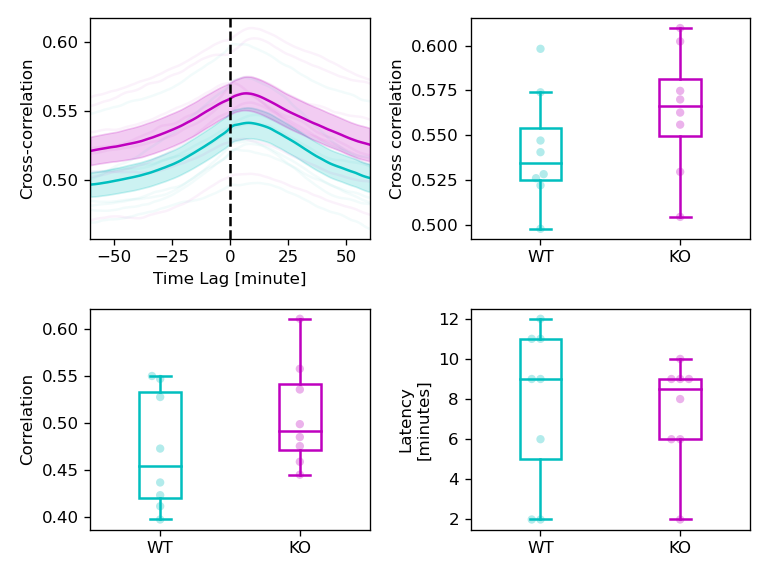

C:\Users\pupil\AppData\Local\Temp\ipykernel_3048\3558646645.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],alpha=.3,order=['WT','KO'])
C:\Users\pupil\AppData\Local\Temp\ipykernel_3048\3558646645.py:50: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],alpha=.3,order=['WT','KO'])
C:\Users\pupil\AppData\Local\Temp\ipykernel_3048\3558646645.py:75: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],alpha=.3,order=['WT','KO'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,1.317680,14,two-sided,0.208767,"[-0.01, 0.06]",0.658840,0.755,0.232926,amplitude
T-test,1.265682,14,two-sided,0.226285,"[-0.03, 0.1]",0.632841,0.724,0.218549,corr_coeff
T-test,-0.222288,14,two-sided,0.827300,"[-3.99, 3.24]",0.111144,0.435,0.054946,latency


In [13]:
import matplotlib
fig,ax = plt.subplots(2,2)
wt_cross_corr_curves = cross_corr_curves[cross_corr_curves['geno']=='WT']
ko_cross_corr_curves = cross_corr_curves[cross_corr_curves['geno']=='KO']
ax[0,0].plot(cc.latencies, wt_cross_corr_curves.iloc[:,2:].T,'c',alpha=.05 )
ax[0,0].plot(cc.latencies, ko_cross_corr_curves.iloc[:,2:].T,'m',alpha=.05 )

wt_mean = wt_cross_corr_curves.iloc[:,2:].T.mean(axis=1)
wt_sem = wt_cross_corr_curves.iloc[:,2:].T.sem(axis=1)
ax[0,0].plot(cc.latencies, wt_mean,'c',alpha=1 )
ax[0,0].fill_between(cc.latencies, y1=wt_mean-wt_sem, y2=wt_mean+wt_sem,color ='c', alpha=.2)

ko_mean = ko_cross_corr_curves.iloc[:,2:].T.mean(axis=1)
ko_sem = ko_cross_corr_curves.iloc[:,2:].T.sem(axis=1)
ax[0,0].plot(cc.latencies, ko_cross_corr_curves.iloc[:,2:].T.mean(axis=1),'m',alpha=1 )
ax[0,0].fill_between(cc.latencies, y1=ko_mean-ko_sem, y2=ko_mean+ko_sem,color ='m', alpha=.2 )

ax[0,0].axvline(0,color='k',linestyle='--')

ax[0,0].set_ylabel('Cross-correlation')
ax[0,0].set_xlabel('Time Lag [minute]')
ax[0,0].set_xlim([-60,60])

PROPS = {'boxprops':{'facecolor':'none'}}
sns.swarmplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[0,1].set_ylabel('Cross correlation')
ax[0,1].set_xlabel('')

box_patches = [patch for patch in ax[0,1].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,0].artists
    box_patches = ax[0,1].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[0,1].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[0,1].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers

sns.swarmplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[1,0].set_ylabel('Correlation')
ax[1,0].set_xlabel('')

box_patches = [patch for patch in ax[1,0].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,0].artists
    box_patches = ax[1,0].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[1,0].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[1,0].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers
        
sns.swarmplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[1,1].set_ylabel('Latency\n[minutes]')
ax[1,1].set_xlabel('')

box_patches = [patch for patch in ax[1,1].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,1].artists
    box_patches = ax[1,1].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[1,1].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[1,1].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers

plt.tight_layout()

ko_cc_amp = cc_data[cc_data['geno']=='KO']['amplitude']
wt_cc_amp = cc_data[cc_data['geno']=='WT']['amplitude']
stats_cc_amp = pg.ttest(ko_cc_amp, wt_cc_amp)
stats_cc_amp['what'] = 'amplitude'

ko_cc_corr_coeff = cc_data[cc_data['geno']=='KO']['corr_coeff']
wt_cc_corr_coeff = cc_data[cc_data['geno']=='WT']['corr_coeff']
stats_cc_corr_coeff = pg.ttest(ko_cc_corr_coeff, wt_cc_corr_coeff)
stats_cc_corr_coeff['what'] = 'corr_coeff'

ko_cc_lat = cc_data[cc_data['geno']=='KO']['latency_minute']
wt_cc_lat = cc_data[cc_data['geno']=='WT']['latency_minute']
stats_cc_lat = pg.ttest(ko_cc_lat, wt_cc_lat)
stats_cc_lat['what'] = 'latency'

pd.concat([stats_cc_amp, stats_cc_corr_coeff,stats_cc_lat] )

## Periodogram

In [3]:
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_data() , total=len(sub) ):
    #rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])

isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)

100%|██████████| 16/16 [00:00<00:00, 44.82it/s]


In [4]:
temp_periodogram_data = list()
mot_periodogram_data = list()

temp_periodogram_amps = {'sub':list(), 'geno':list(), '24':list(), '12':list(), '8':list()}
mot_periodogram_amps = {'sub':list(), 'geno':list(), '24':list(), '12':list(), '8':list()}

for i,(geno,chi) in enumerate(temperature.columns):
    temp = Periodogram(temperature[geno][chi],fs=60)
    mot = Periodogram(motion[geno][chi],fs=60)
    
    temp_ps = pd.DataFrame(temp.power_spectrum,index=temp.period).T 
    temp_ps.insert(0, 'sub', chi)
    temp_ps.insert(1, 'geno', geno)
    temp_periodogram_data.append(temp_ps)
    
    mot_ps = pd.DataFrame(mot.power_spectrum,index=mot.period).T 
    mot_ps.insert(0, 'sub', chi)
    mot_ps.insert(1, 'geno', geno)
    mot_periodogram_data.append(mot_ps)
    
    temp_periodogram_amps['sub'].append(chi)
    temp_periodogram_amps['geno'].append(geno)
    temp_periodogram_amps['24'].append(float( temp.interp_func(24) ))
    temp_periodogram_amps['12'].append(float( temp.interp_func(12) ))
    temp_periodogram_amps['8'].append(float( temp.interp_func(8) ))
    
    mot_periodogram_amps['sub'].append(chi)
    mot_periodogram_amps['geno'].append(geno)
    mot_periodogram_amps['24'].append(float( mot.interp_func(24) ))
    mot_periodogram_amps['12'].append(float( mot.interp_func(12) ))
    mot_periodogram_amps['8'].append(float( mot.interp_func(8) ))
    
temp_periodogram_data = pd.concat(temp_periodogram_data)
mot_periodogram_data = pd.concat(mot_periodogram_data)

temp_periodogram_amps = pd.DataFrame(temp_periodogram_amps).infer_objects()
mot_periodogram_amps = pd.DataFrame(mot_periodogram_amps).infer_objects()


<IPython.core.display.Javascript object>


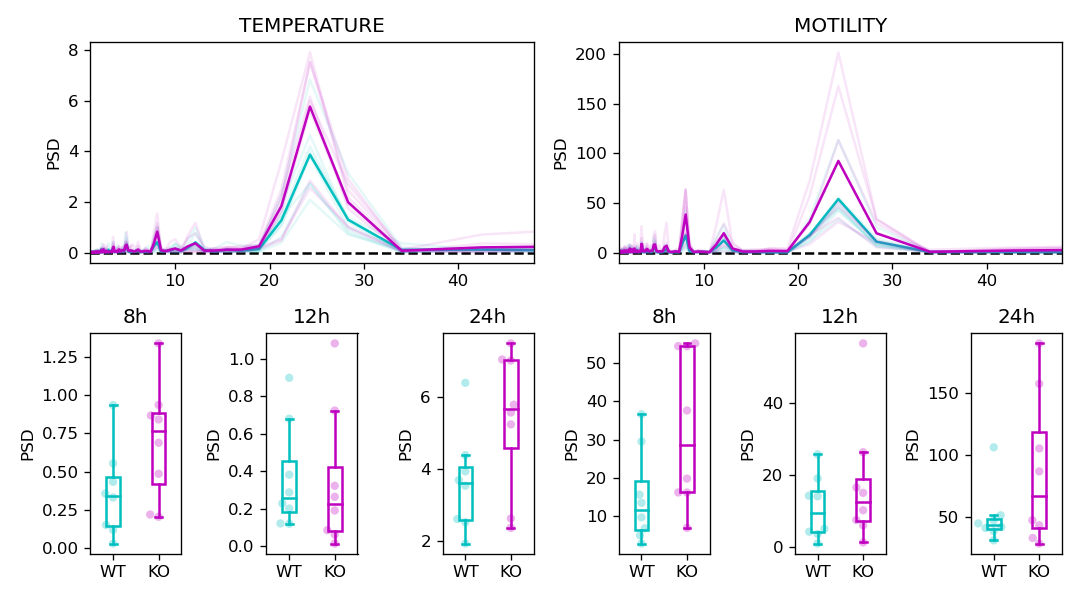

C:\Users\pupil\AppData\Local\Temp\ipykernel_7536\4129271960.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_7536\4129271960.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_7536\4129271960.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_7536\4129271960.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_7536\4129271960.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,-2.083076,14,two-sided,0.056059,"[-3.59, 0.05]",1.041538,1.631,0.491922,t24
T-test,0.131655,14,two-sided,0.897131,"[-0.33, 0.38]",0.065827,0.43,0.051732,t12
T-test,-1.964412,14,two-sided,0.069651,"[-0.7, 0.03]",0.982206,1.424,0.448154,t8
T-test,-1.575074,14,two-sided,0.137561,"[-84.97, 13.01]",0.787537,0.95,0.311589,m24
T-test,-0.946651,14,two-sided,0.359871,"[-21.57, 8.36]",0.473325,0.577,0.142975,m12
T-test,-2.121936,14,two-sided,0.052169,"[-35.39, 0.19]",1.060968,1.707,0.506301,m8


In [6]:
wt_temp_periodogram_data = temp_periodogram_data[temp_periodogram_data['geno']=='WT'].iloc[:,2:].T
ko_temp_periodogram_data = temp_periodogram_data[temp_periodogram_data['geno']=='KO'].iloc[:,2:].T

wt_mot_periodogram_data = mot_periodogram_data[mot_periodogram_data['geno']=='WT'].iloc[:,2:].T
ko_mot_periodogram_data = mot_periodogram_data[mot_periodogram_data['geno']=='KO'].iloc[:,2:].T

#fig,ax=plt.subplots()
fig, ax = plt.subplot_mosaic(
    [["temperature_spectrum", "temperature_spectrum", "temperature_spectrum","motion_spectrum", "motion_spectrum", "motion_spectrum"],
     ["t8", "t12", "t24", "m8", "m12", "m24"]], figsize=(9,5)
)

ax["temperature_spectrum"].axhline(0,color='k', linestyle='--')
ax["temperature_spectrum"].plot(wt_temp_periodogram_data.index, wt_temp_periodogram_data,'c',alpha=0.1)
ax["temperature_spectrum"].plot(wt_temp_periodogram_data.index, wt_temp_periodogram_data.mean(axis=1),'c',alpha=1)

ax["temperature_spectrum"].plot(ko_temp_periodogram_data.index, ko_temp_periodogram_data,'m',alpha=0.1)
ax["temperature_spectrum"].plot(ko_temp_periodogram_data.index, ko_temp_periodogram_data.mean(axis=1),'m',alpha=1)

ax["temperature_spectrum"].set_xlim([1,48])
ax['temperature_spectrum'].set_ylabel('PSD')
ax['temperature_spectrum'].set_title('TEMPERATURE')

ax["motion_spectrum"].axhline(0,color='k', linestyle='--')
ax["motion_spectrum"].plot(wt_mot_periodogram_data.index, wt_mot_periodogram_data,'c',alpha=0.1)
ax["motion_spectrum"].plot(wt_mot_periodogram_data.index, wt_mot_periodogram_data.mean(axis=1),'c',alpha=1)

ax["motion_spectrum"].plot(ko_mot_periodogram_data.index, ko_mot_periodogram_data,'m',alpha=0.1)
ax["motion_spectrum"].plot(ko_mot_periodogram_data.index, ko_mot_periodogram_data.mean(axis=1),'m',alpha=1)

ax["motion_spectrum"].set_xlim([1,48])
ax['motion_spectrum'].set_ylabel('PSD')
ax['motion_spectrum'].set_title('MOTILITY')

swarmbox(data=temp_periodogram_amps,x='geno',y='24',ax=ax['t24'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['24']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['24']
temp_periodogram_amps_stats_24 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_24['what'] = 't24'
ax['t24'].set_ylabel('PSD')
ax['t24'].set_xlabel('')
ax['t24'].set_title('24h')

swarmbox(data=mot_periodogram_amps,x='geno',y='24',ax=ax['m24'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['24']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['24']
mot_periodogram_amps_stats_24 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_24['what'] = 'm24'
ax['m24'].set_ylabel('PSD')
ax['m24'].set_xlabel('')
ax['m24'].set_title('24h')

swarmbox(data=temp_periodogram_amps,x='geno',y='12',ax=ax['t12'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['12']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['12']
temp_periodogram_amps_stats_12 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_12['what'] = 't12'
ax['t12'].set_ylabel('PSD')
ax['t12'].set_xlabel('')
ax['t12'].set_title('12h')

swarmbox(data=mot_periodogram_amps,x='geno',y='12',ax=ax['m12'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['12']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['12']
mot_periodogram_amps_stats_12 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_12['what'] = 'm12'
ax['m12'].set_ylabel('PSD')
ax['m12'].set_xlabel('')
ax['m12'].set_title('12h')

swarmbox(data=temp_periodogram_amps,x='geno',y='8',ax=ax['t8'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['8']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['8']
temp_periodogram_amps_stats_8 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_8['what'] = 't8'
ax['t8'].set_ylabel('PSD')
ax['t8'].set_xlabel('')
ax['t8'].set_title('8h')

swarmbox(data=mot_periodogram_amps,x='geno',y='8',ax=ax['m8'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['8']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['8']
mot_periodogram_amps_stats_8 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_8['what'] = 'm8'
ax['m8'].set_ylabel('PSD')
ax['m8'].set_xlabel('')
ax['m8'].set_title('8h')

plt.tight_layout()
pd.concat([temp_periodogram_amps_stats_24, temp_periodogram_amps_stats_12, temp_periodogram_amps_stats_8,
          mot_periodogram_amps_stats_24,mot_periodogram_amps_stats_12,mot_periodogram_amps_stats_8])


## Cosinor Analysis

<IPython.core.display.Javascript object>


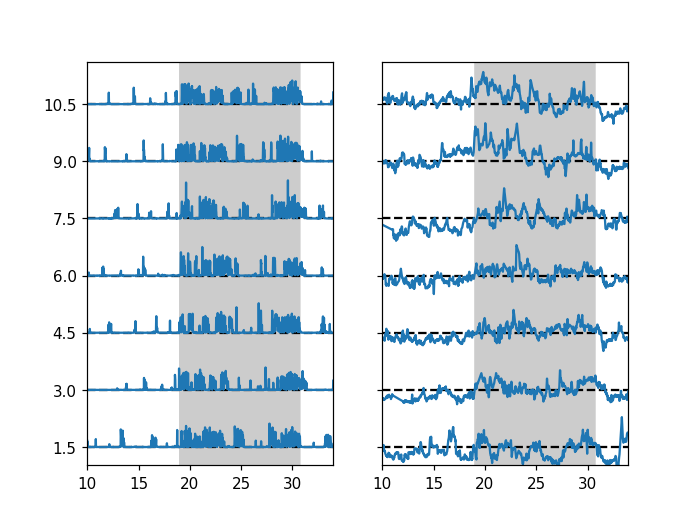

In [4]:
topo=4
temperature_each_day = sub.get_days_df(topo,'temp_rt_corrected')
motion_each_day = sub.get_days_df(topo,'distance')
isDay_each_day = sub.get_days_df(topo,'isDay').mean(axis=1)

temperature_each_day.index = 10+(temperature_each_day.index/60)
motion_each_day.index = 10+(motion_each_day.index/60)
isDay_each_day.index = 10+(isDay_each_day.index/60)

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
actogram(motion_each_day,ax=ax[0],baseline=True,isDay=isDay_each_day)
actogram(temperature_each_day,baseline=True,isDay=isDay_each_day,ax=ax[1])
    

In [43]:

group_cosinor = list()
for s,data_min in sub.iter_data():
    temperature = data_min['temp_rt_diff']
    temperature.index = 10+(temperature.index/60)
    cosinor = Cosinor(temperature, temperature.index, fixed24=True, acroWrap=True)
    cosinor.components['id']=s['id']
    cosinor.components['geno']=s['geno']
    group_cosinor.append( cosinor.components ) 
group_cosinor = pd.concat(group_cosinor)
#fig,ax = plt.subplots(figsize=(8,2))
#ax.plot( cosinor.time,temperature)
#ax.plot( cosinor.time,cosinor.curve)
#ax.axhline(cosinor.components['mesor'].values, color='k', linestyle='--')
#ax.plot(cosinor.components['acrophase'].values, cosinor.components['mesor'].values + cosinor.components['amplitude'].values,'rs',mfc='None')
#ax.plot()


,mesor,amplitude,period,acrophase,r2,id,geno
0,3.439359,0.539974,23.99,1.605,0.366138,KO_99,KO


<IPython.core.display.Javascript object>


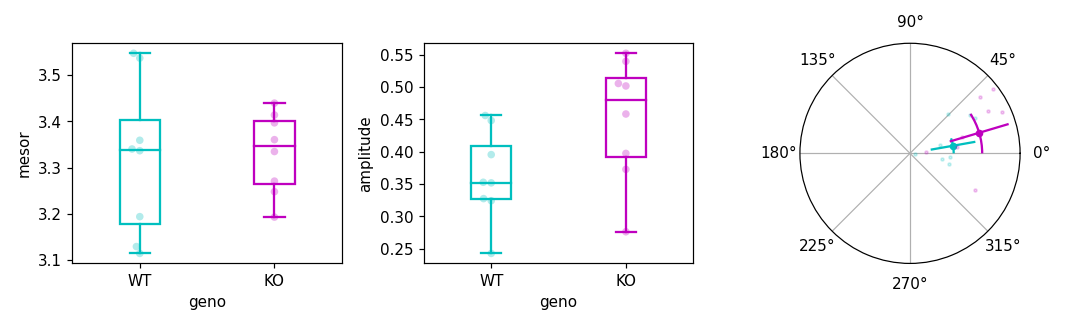

C:\Users\pupil\AppData\Local\Temp\ipykernel_8596\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_8596\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,-0.186170,14,two-sided,0.854982,"[-0.16, 0.13]",0.093085,0.433,0.053466,mesor
T-test,-2.109976,14,two-sided,0.053339,"[-0.18, 0.0]",1.054988,1.683,0.501876,amplitude
T-test,-1.381042,14,two-sided,0.188914,"[-0.13, 0.03]",0.690521,0.796,0.251170,r2


In [130]:
from scipy.stats import circmean,circstd
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133, projection='polar')

swarmbox(data=group_cosinor,x='geno',y='mesor',ax=ax1,palette={'WT':'c','KO':'m'},order=['WT','KO'])
swarmbox(data=group_cosinor,x='geno',y='amplitude',ax=ax2,palette={'WT':'c','KO':'m'},order=['WT','KO'])

wt_cosinor = group_cosinor[group_cosinor['geno']=='WT']
ax3.plot(hour2radians(wt_cosinor['acrophase']),wt_cosinor['amplitude'],'co', markersize=2,alpha=.2)
wt_circ_mean = circmean(hour2radians(wt_cosinor['acrophase']))
wt_circ_std = circmean(hour2radians(wt_cosinor['acrophase']))
ax3.plot(wt_circ_mean ,wt_cosinor['amplitude'].mean(),'co', markersize=4)
wt_amp_std = wt_cosinor['amplitude'].std()
ax3.errorbar(wt_circ_mean, wt_cosinor['amplitude'].mean(), yerr=wt_amp_std, xerr=wt_circ_std, capsize=0,linestyle='None',color='c')

ko_cosinor = group_cosinor[group_cosinor['geno']=='KO']
ax3.plot(hour2radians(ko_cosinor['acrophase']),ko_cosinor['amplitude'],'mo', markersize=2,alpha=.2)
ko_circ_mean = circmean(hour2radians(ko_cosinor['acrophase']))
ko_circ_std = circmean(hour2radians(ko_cosinor['acrophase']))
ax3.plot(ko_circ_mean ,ko_cosinor['amplitude'].mean(),'mo', markersize=4)
ko_amp_std = ko_cosinor['amplitude'].std()
ax3.errorbar(ko_circ_mean, ko_cosinor['amplitude'].mean(), yerr=ko_amp_std, xerr=ko_circ_std, capsize=0, linestyle='None',color='m')

ax3.set_yticks([])
plt.tight_layout()

cos_stat_mesor = pg.ttest(wt_cosinor['mesor'],ko_cosinor['mesor'])
cos_stat_mesor['what']  = 'mesor'
cos_stat_amp = pg.ttest(wt_cosinor['amplitude'],ko_cosinor['amplitude'])
cos_stat_amp['what']  = 'amplitude'
cos_stat_r2 = pg.ttest(wt_cosinor['r2'],ko_cosinor['r2'])
cos_stat_r2['what']  = 'r2'

pd.concat([cos_stat_mesor,cos_stat_amp,cos_stat_r2])

<IPython.core.display.Javascript object>


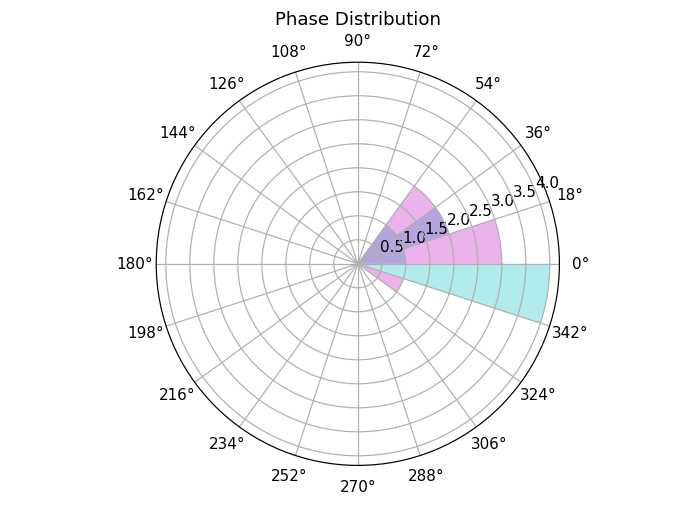

In [117]:

def plot_polar_histogram(phases,bins = 20,ax=None,color='tab:blue',alpha=.3):

    phases_radians = np.deg2rad(360 * phases / 24)
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    
    # Compute the bin edges
    bin_edges = np.linspace(0, 2 * np.pi, bins + 1)
    
    # Wrap phases to the range [0, 2*pi)
    wrapped_phases = np.mod(phases_radians, 2 * np.pi)
    
    # Compute the histogram
    _, bins, _ = ax.hist(wrapped_phases, bins=bin_edges, color=color, alpha=alpha )
    
    # Set the label positions
    ax.set_xticks(bins[:-1])
    ax.set_xticklabels([f'{int(np.rad2deg(b))}°' for b in bins[:-1]])
    
    # Set the title and display the plot
    ax.set_title('Phase Distribution')
    
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plot_polar_histogram(wt_cosinor['acrophase'],ax=ax,color='c')
plot_polar_histogram(ko_cosinor['acrophase'],ax=ax,color='m')

In [105]:
wt_cosinor['acrophase']

0    23.628
0    23.368
0    23.257
0    22.977
0     3.078
0     1.046
0     2.189
0     1.901
Name: acrophase, dtype: float64